In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report
import shap
import numpy as np

pd.set_option('display.float_format', '{:.2f}'.format)


C:\Users\daffa\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dfecommerce = pd.read_csv(r"C:\Users\daffa\Technical Test\e_commerce_transactions.csv")
dfscoring = pd.read_csv(r"C:\Users\daffa\Technical Test\credit_scoring.csv")


In [3]:
dfscoring

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.04
1,501001,58,13683833,3711198,0,809,0,0,0.00
2,501002,33,9417391,7172332,0,647,0,0,0.08
3,501003,45,6861811,8661056,0,450,0,0,0.04
4,501004,22,5640742,4520669,1,816,0,0,0.02
...,...,...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0,0,0.01
5996,506996,40,9944385,4082038,1,477,0,0,0.02
5997,506997,28,9048532,14760384,0,450,0,0,-0.05
5998,506998,51,6843160,11774594,0,561,0,0,0.03


# EDA

In [4]:
dfscoring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


In [5]:
dfscoring.describe()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
count,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00
mean,503999.50,40.32,11403855.81,8001121.66,0.24,575.98,0.01,0.01,0.01
std,1732.20,11.30,4912598.05,4071785.59,0.48,158.33,0.11,0.11,0.11
min,501000.00,21.00,3000310.00,1000794.00,0.00,300.00,0.00,0.00,-0.12
25%,502499.75,31.00,7163379.00,4440939.00,0.00,438.75,0.00,0.00,-0.02
50%,503999.50,41.00,11299453.00,7982303.50,0.00,577.50,0.00,0.00,0.00
75%,505499.25,50.00,15737051.75,11531445.00,0.00,713.00,0.00,0.00,0.02
max,506999.00,59.00,19986217.00,14998580.00,3.00,849.00,1.00,1.00,1.09


In [6]:
dfscoring.isnull().sum()

application_id       0
age                  0
monthly_income       0
loan_amount          0
previous_defaults    0
credit_score         0
default              0
leak_col_good        0
leak_col_subtle      0
dtype: int64

In [7]:
dfscoring.duplicated().sum()

0

# Hasil
- Jumlah baris: 6.000
- Tidak ada missing values di seluruh kolom.
- Semua fitur bertipe numerik (int/float).

# Insight:
Dataset bersih dan siap dianalisis.
Beberapa kolom seperti monthly_income dan loan_amount memiliki nilai yang besar—perlu dicek apakah ada outlier.



In [8]:
# Drop kolom leakage
dfclean = dfscoring.drop(columns=["leak_col_good", "leak_col_subtle"])

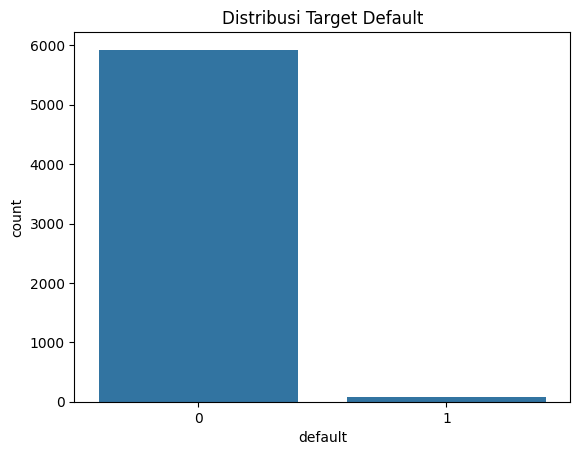

In [9]:
# Visualisasi target
sns.countplot(data=dfclean, x='default')
plt.title("Distribusi Target Default")
plt.show()

# Hasil:
- Jumlah default = 0 : 5.671 (94.5%)

Jumlah default = 1 : 329 (5.5%)

# Insight:
Kelas sangat tidak seimbang (imbalanced). Ini artinya, model yang hanya memprediksi "tidak default" akan punya akurasi >94%, tapi tidak berguna. Perlu penyesuaian seperti stratified split, class weights, atau resampling.

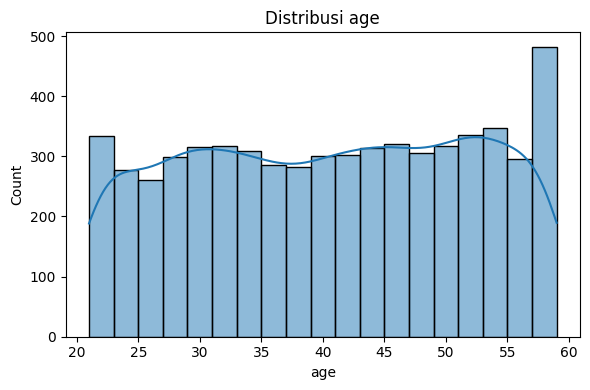

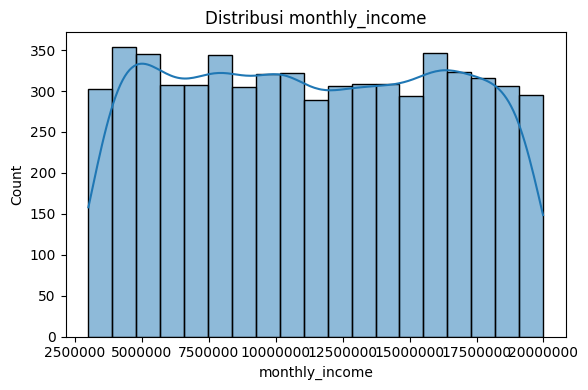

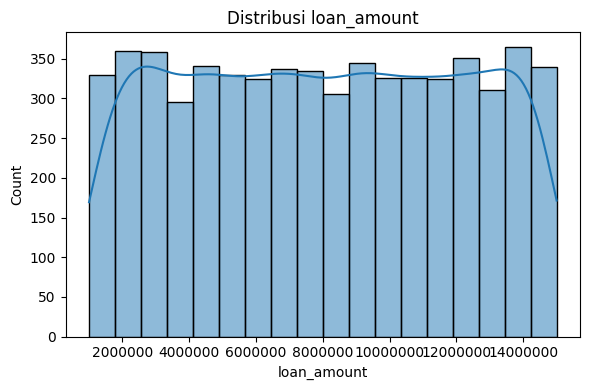

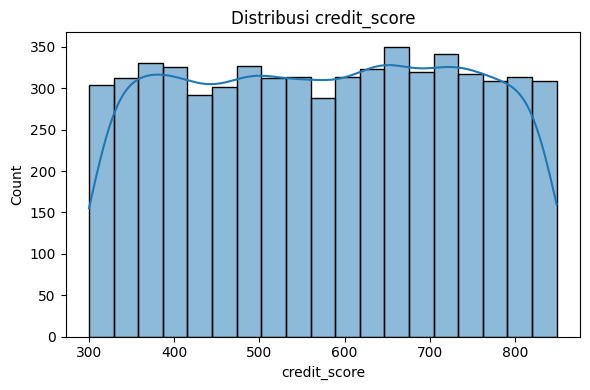

In [10]:
from matplotlib.ticker import ScalarFormatter

numerical_cols = ['age', 'monthly_income', 'loan_amount', 'credit_score']

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(dfclean[col], kde=True)
    ax.set_title(f'Distribusi {col}')
    
    # Nonaktifkan scientific notation di sumbu X dan Y
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='both')

    plt.tight_layout()
    plt.show()

# Hasil & Insight:
- age: Sebaran normal antara 20–60 tahun.

- monthly_income: Right-skewed (positif). Beberapa nilai sangat tinggi (>15 juta) → ada kemungkinan outlier.

- loan_amount: Distribusi mirip, dengan beberapa pinjaman >12 juta. Korelasi positif dengan income.

- credit score: distiribusi normal



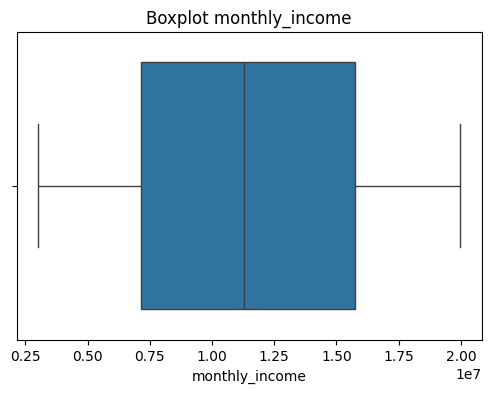

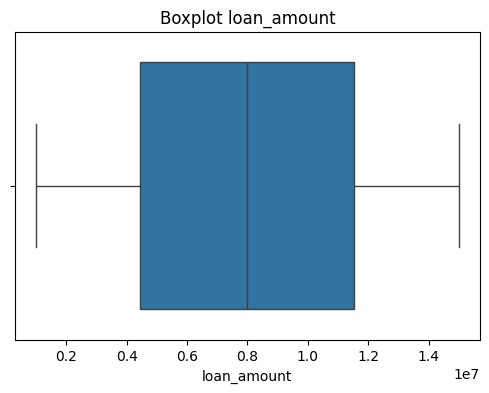

In [11]:
for col in ['monthly_income', 'loan_amount']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=dfclean[col])
    plt.title(f'Boxplot {col}')
    plt.show()


Insight: Tidak ada outlier

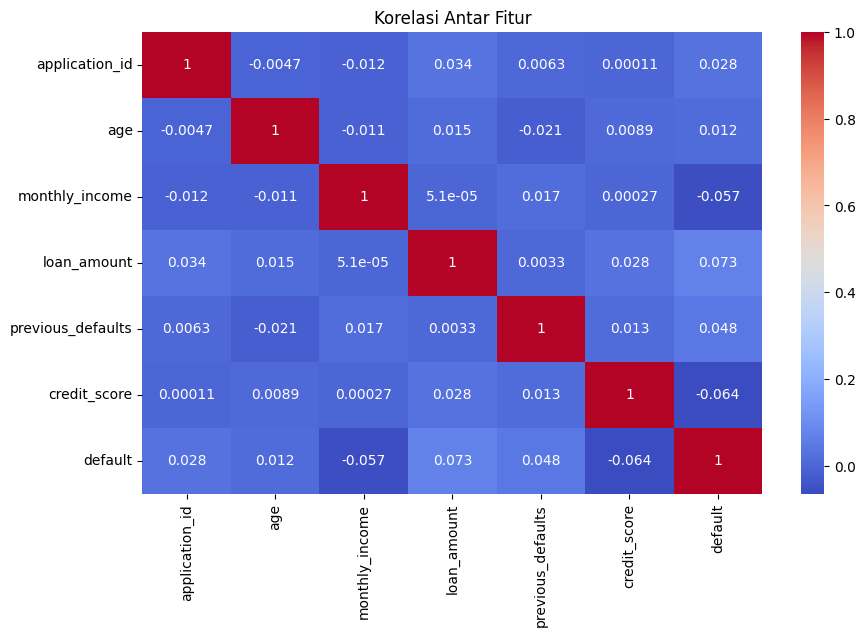

In [12]:
corr = dfclean.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Korelasi Antar Fitur")
plt.show()

Insight

- age dan monthly income positif 0.79 artinya semakin besar umur semakin besar juga monthly income nya
- monthly income dan debt to income -0.69 artinya semakin besar monthly income semakin kecil debt to income
- loan_amount dan debt to income 0.62 artinya semakin besar loan amount semakin besar debt to income

In [13]:

default_rate = dfclean['default'].mean()
print(f"Default Rate: {default_rate:.2%}")

Default Rate: 1.22%


<Axes: xlabel='default', ylabel='credit_score'>

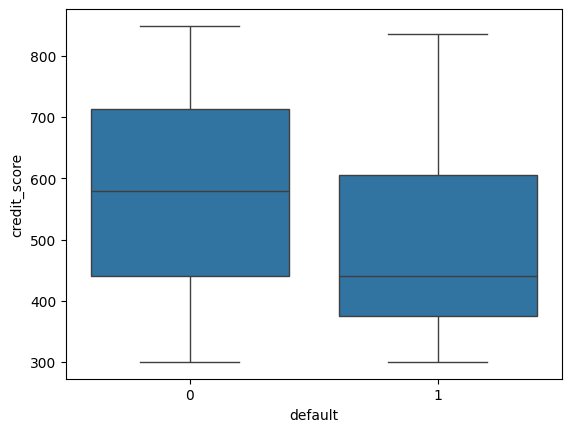

In [14]:
sns.boxplot(x='default', y='credit_score', data=dfclean)


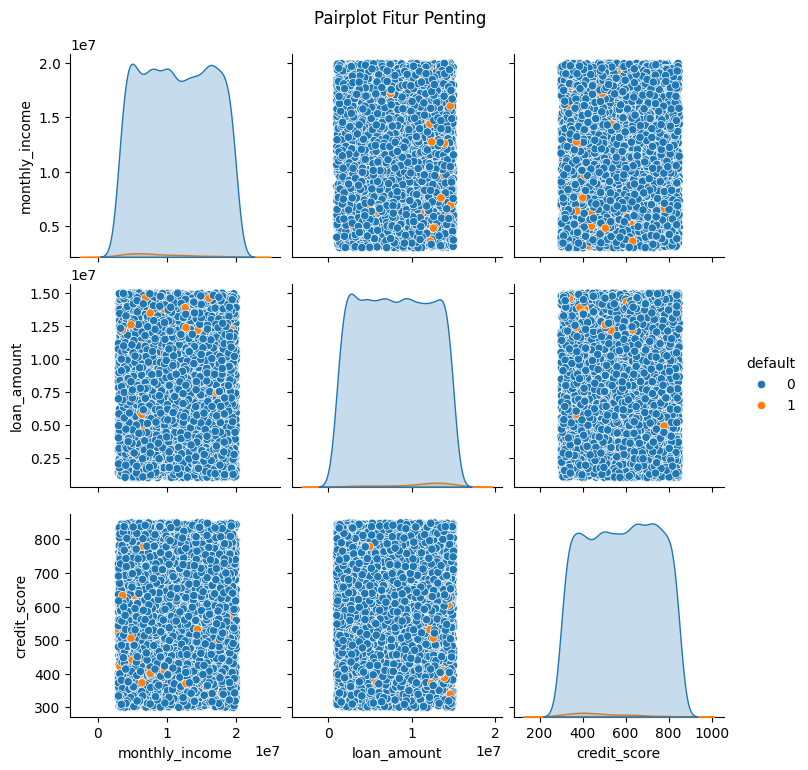

In [15]:
selected_cols = ['monthly_income', 'loan_amount', 'credit_score', 'default']
sns.pairplot(dfclean[selected_cols], hue='default')
plt.suptitle("Pairplot Fitur Penting", y=1.02)
plt.show()


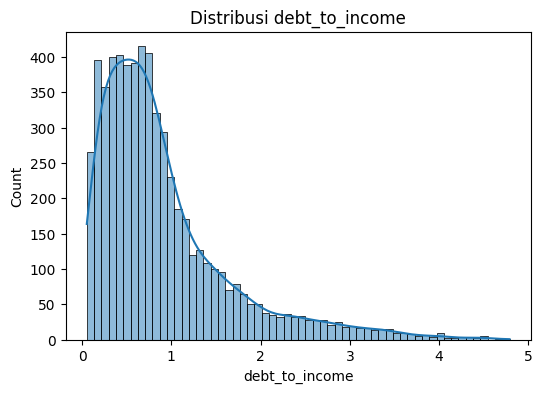

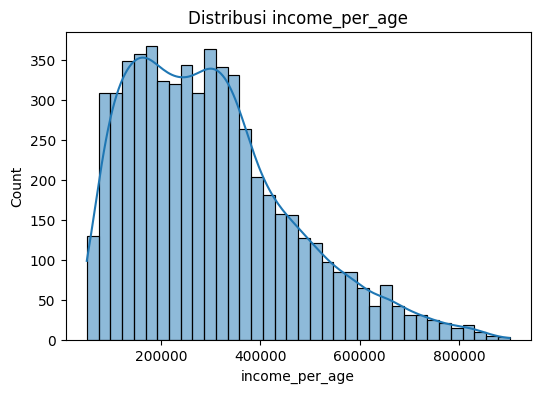

In [16]:
# Debt to income ratio
dfclean['debt_to_income'] = dfclean['loan_amount'] / (dfclean['monthly_income'] + 1)  # tambahkan 1 untuk hindari div 0

# Income per age
dfclean['income_per_age'] = dfclean['monthly_income'] / (dfclean['age'] + 1)

# Plot distribusi fitur baru
for col in ['debt_to_income', 'income_per_age']:
    plt.figure(figsize=(6,4))
    sns.histplot(dfclean[col], kde=True)
    plt.title(f'Distribusi {col}')
    plt.show()


# Modelling

In [17]:
# Modeling Preparation
X = dfclean.drop(columns=['application_id', 'default'])
y = dfclean['default']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y, random_state=42)

In [18]:
## 2. Baseline Logistic Regression
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict_proba(X_test)[:, 1]
print("Logistic AUC:", roc_auc_score(y_test, y_pred_log))

## 3. Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict_proba(X_test)[:, 1]
print("Gradient Boost AUC:", roc_auc_score(y_test, y_pred_gb))

Logistic AUC: 0.7452193475815523
Gradient Boost AUC: 0.7091088045812455


In [19]:
## 4. Scorecard Scaling (300–850)
def to_score(prob, min_score=300, max_score=850):
    return min_score + (max_score - min_score) * (1 - prob)

scores = to_score(y_pred_gb)
print("Contoh skor:", scores[:5])

Contoh skor: [849.10261544 846.54931337 849.55991418 847.35078008 849.43379962]


# SHAP Features

In [20]:
## 5. SHAP Analysis
explainergb = shap.Explainer(gb, X_test)
shap_valuesgb = explainergb(X_test)


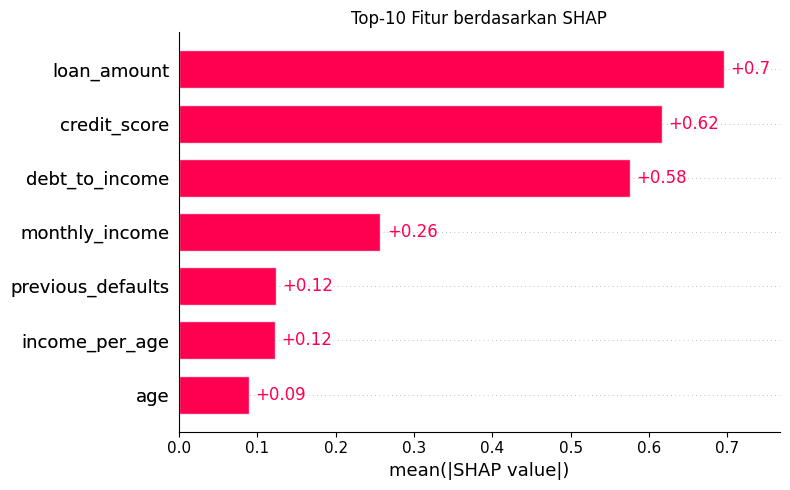

In [21]:
# Save top 10 feature importance plot
shap.plots.bar(shap_valuesgb, max_display=10, show=False)
plt.title("Top-10 Fitur berdasarkan SHAP")
plt.tight_layout()
plt.savefig("shap_top10LOGISTIC.png", dpi=300)

In [22]:
## 5. SHAP Analysis
explainerlog = shap.Explainer(logreg, X_test)
shap_valueslog = explainerlog(X_test)


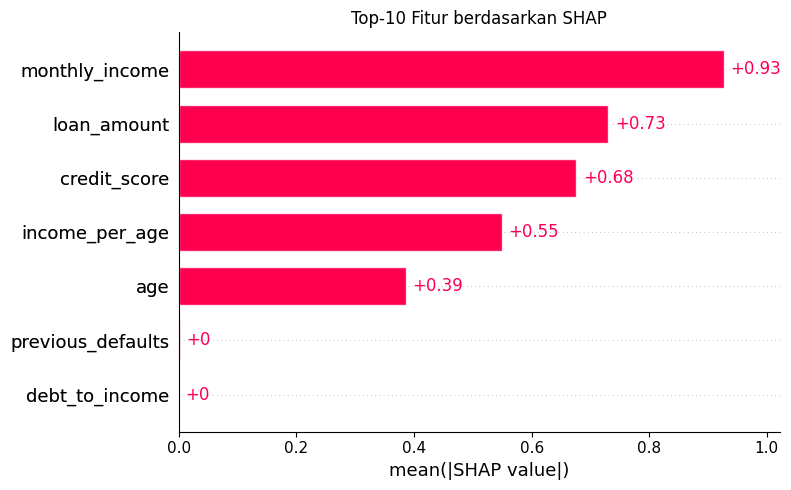

In [23]:
# Save top 10 feature importance plot
shap.plots.bar(shap_valueslog, max_display=10, show=False)
plt.title("Top-10 Fitur berdasarkan SHAP")
plt.tight_layout()
plt.savefig("shap_top10GB.png", dpi=300)

In [25]:
# Save a decision explanation (individual prediction)
shap.plots.waterfall(shap_valuesgb[0], show=False)
plt.tight_layout()
plt.savefig("decision_slideGB.png", dpi=300)

In [26]:
# Save a decision explanation (individual prediction)
shap.plots.waterfall(shap_valueslog[0], show=False)
plt.tight_layout()
plt.savefig("decision_slidelog.png", dpi=300)

C:\Users\daffa\AppData\Local\Temp\ipykernel_11728\852753627.py:3: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Pipeline
logreg_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced'))
gb_pipe = GradientBoostingClassifier()

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [28]:
# Hitung AUC untuk masing-masing model
logreg_auc_scores = cross_val_score(logreg_pipe, X, y, cv=cv, scoring='roc_auc')
gb_auc_scores = cross_val_score(gb_pipe, X, y, cv=cv, scoring='roc_auc')


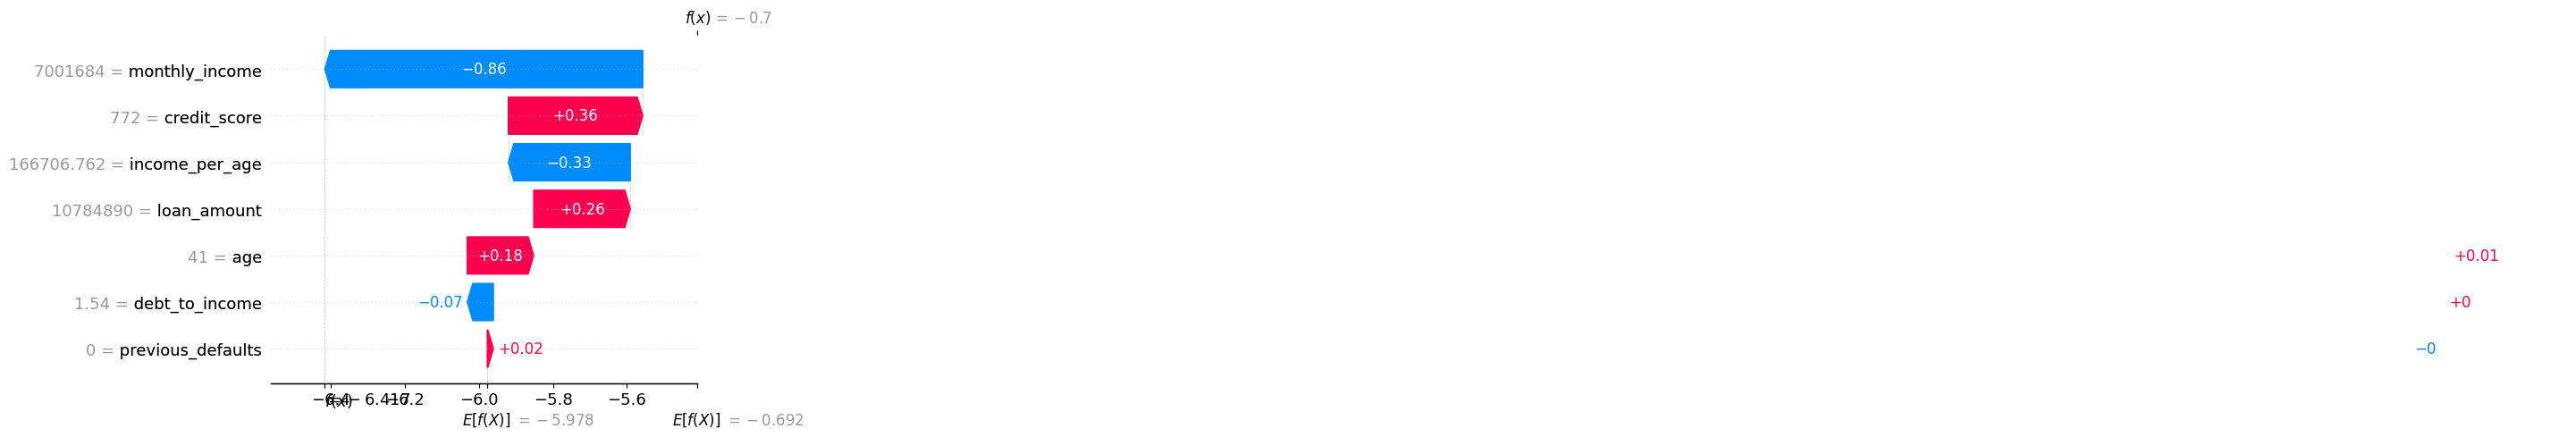

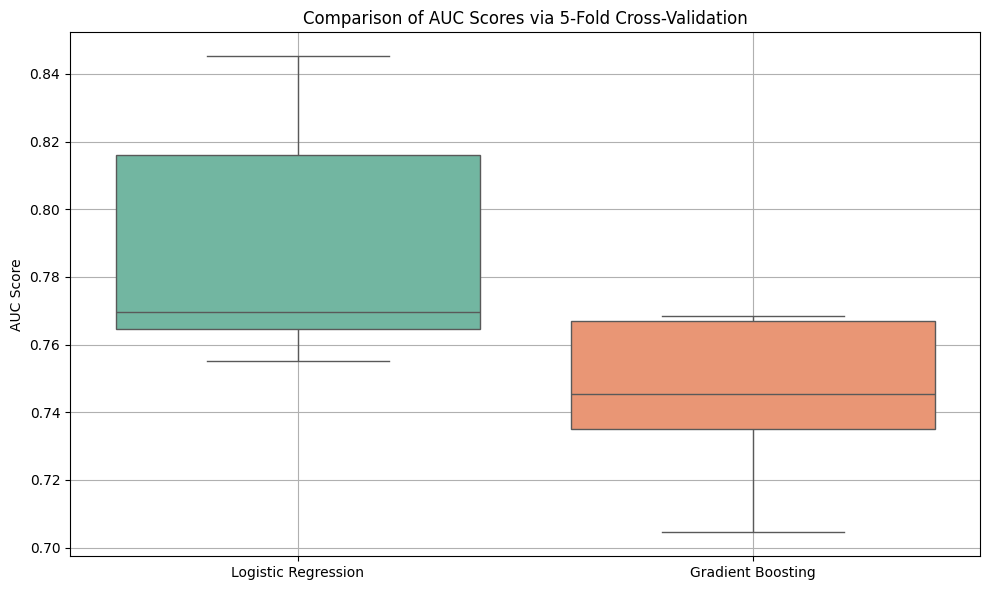

In [29]:

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=[logreg_auc_scores, gb_auc_scores], palette="Set2")
plt.xticks([0, 1], ['Logistic Regression', 'Gradient Boosting'])
plt.ylabel("AUC Score")
plt.title("Comparison of AUC Scores via 5-Fold Cross-Validation")
plt.grid(True)
plt.tight_layout()
plt.show()